GPU Available: True
Device Name: Tesla P100-PCIE-16GB
Memory Allocated: 0.0 GB
Memory Cached: 0.0 GB


Resolving data files:   0%|          | 0/12729 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

model.safetensors:   0%|          | 0.00/349M [00:00<?, ?B/s]

/tmp/ipykernel_35/3571110946.py:133: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/10:   0%|          | 0/1289 [00:00<?, ?it/s]/tmp/ipykernel_35/3571110946.py:172: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10: 100%|██████████| 1289/1289 [12:34<00:00,  1.71it/s, Loss=587.661, Train Acc=88.84%]
/tmp/ipykernel_35/3571110946.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 Summary: Train Acc=88.84%, Val Acc=96.42%


Epoch 2/10: 100%|██████████| 1289/1289 [11:11<00:00,  1.92it/s, Loss=360.334, Train Acc=96.82%]


Epoch 2 Summary: Train Acc=96.82%, Val Acc=98.17%


Epoch 3/10: 100%|██████████| 1289/1289 [11:16<00:00,  1.90it/s, Loss=327.329, Train Acc=97.06%]


Epoch 3 Summary: Train Acc=97.06%, Val Acc=98.60%


Epoch 4/10: 100%|██████████| 1289/1289 [11:13<00:00,  1.91it/s, Loss=312.208, Train Acc=96.95%]


Epoch 4 Summary: Train Acc=96.95%, Val Acc=98.43%


Epoch 5/10: 100%|██████████| 1289/1289 [11:10<00:00,  1.92it/s, Loss=277.271, Train Acc=97.17%]


Epoch 5 Summary: Train Acc=97.17%, Val Acc=98.60%


Epoch 6/10: 100%|██████████| 1289/1289 [11:15<00:00,  1.91it/s, Loss=232.420, Train Acc=97.33%]


Epoch 6 Summary: Train Acc=97.33%, Val Acc=98.60%


Epoch 7/10: 100%|██████████| 1289/1289 [11:13<00:00,  1.92it/s, Loss=189.823, Train Acc=97.43%]


Epoch 7 Summary: Train Acc=97.43%, Val Acc=98.52%


Epoch 8/10: 100%|██████████| 1289/1289 [11:11<00:00,  1.92it/s, Loss=160.419, Train Acc=97.63%]


Epoch 8 Summary: Train Acc=97.63%, Val Acc=98.69%


Epoch 9/10: 100%|██████████| 1289/1289 [11:12<00:00,  1.92it/s, Loss=141.806, Train Acc=97.57%]


Epoch 9 Summary: Train Acc=97.57%, Val Acc=98.69%


Epoch 10/10: 100%|██████████| 1289/1289 [11:04<00:00,  1.94it/s, Loss=120.714, Train Acc=97.50%]


Epoch 10 Summary: Train Acc=97.50%, Val Acc=98.87%
Test Accuracy: 0.9937156323644933
                                 precision    recall  f1-score   support

         01. Anabas Testudineus       1.00      1.00      1.00        53
            02. Batasio Tengana       1.00      1.00      1.00        38
            03. Channa Punctata       1.00      1.00      1.00        47
     04.Heteropneustes fossilis       1.00      1.00      1.00        59
05. Marcrobrachium Malcoimsonii       1.00      1.00      1.00        28
       06. Mstacembelus Armatus       1.00      1.00      1.00        55
          07. Ompok Bimaculatus       1.00      0.98      0.99        51
                    08. Puntius       1.00      1.00      1.00        53
           09. Labeo nigrescens       1.00      1.00      1.00        21
                10. Catla catla       1.00      1.00      1.00        35
                11.Wallago attu       1.00      1.00      1.00        50
    12. Ctenopharyngodon idella       

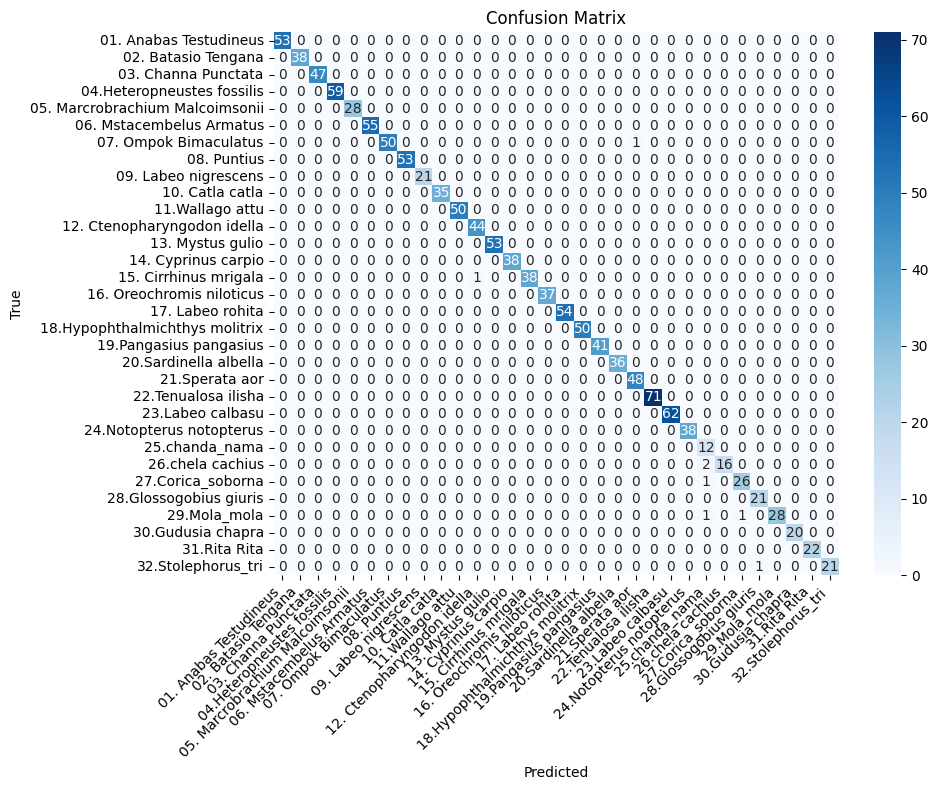

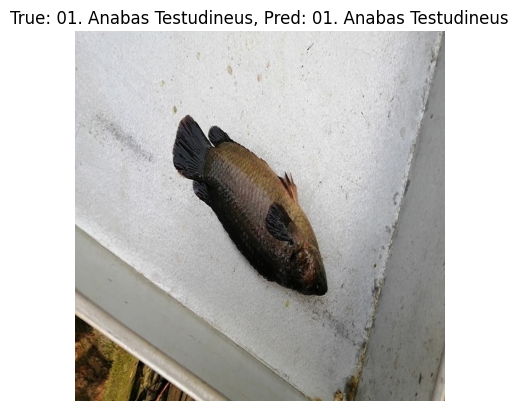

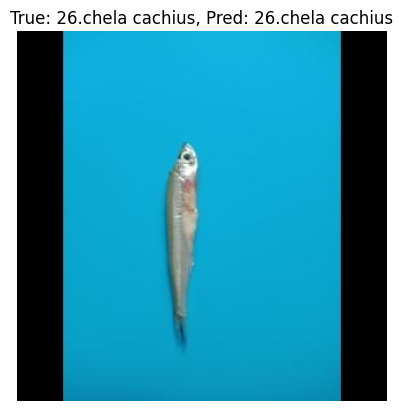

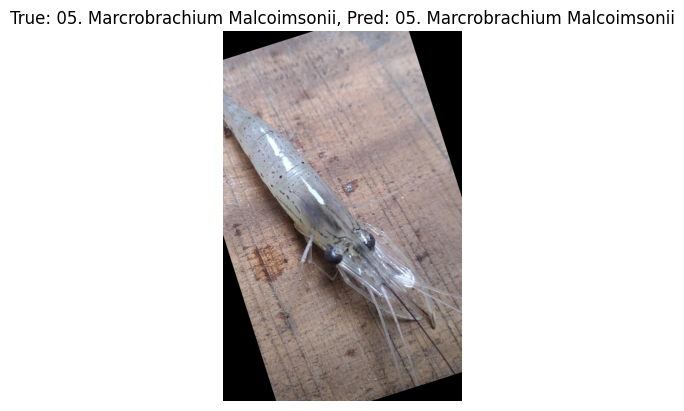

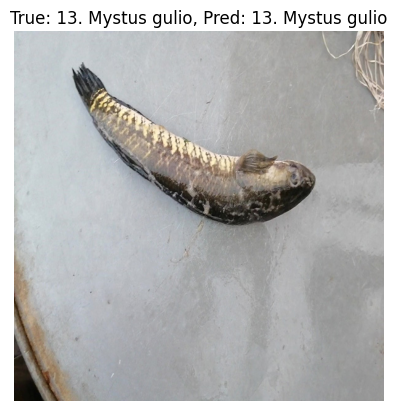

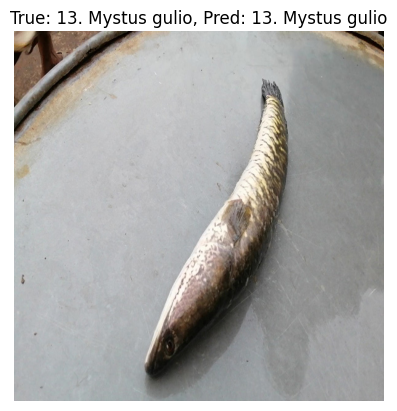

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop, Compose, Normalize, RandomHorizontalFlip,
    RandomResizedCrop, ToTensor, Resize
)
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import random
from PIL import Image
import PIL
import copy
import numpy as np

# Prevent PIL Decompression Bomb Warning
Image.MAX_IMAGE_PIXELS = None
PIL.Image.warnings.simplefilter('ignore', PIL.Image.DecompressionBombWarning)

# Check GPU
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(0))
    print("Memory Allocated:", round(torch.cuda.memory_allocated(0)/1024**3, 2), "GB")
    print("Memory Cached:", round(torch.cuda.memory_reserved(0)/1024**3, 2), "GB")

# EWC class for continual learning
class EWC:
    def __init__(self, model, dataset, device, importance=1000):
        self.model = model
        self.dataset = dataset
        self.device = device
        self.importance = importance
        self.params = {n: p.clone().detach() for n, p in model.named_parameters() if p.requires_grad}
        self._precision_matrices = self._calculate_precision_matrices()

    def _calculate_precision_matrices(self):
        precision_matrices = {}
        for n, p in self.params.items():
            precision_matrices[n] = torch.zeros_like(p).to(self.device)

        self.model.eval()
        dataloader = DataLoader(self.dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
        num_batches = len(dataloader)
        
        for batch in dataloader:
            self.model.zero_grad()
            inputs = batch['pixel_values'].to(self.device)
            outputs = self.model(inputs)
            outputs.sum().backward()
            
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    precision_matrices[n] += p.grad.data ** 2 / num_batches

        return precision_matrices

    def penalty(self, model):
        loss = 0
        for n, p in model.named_parameters():
            if n in self.params:
                _loss = self._precision_matrices[n] * (p - self.params[n]) ** 2
                loss += _loss.sum()
        return self.importance * loss

# Load Dataset
dataset = load_dataset('/kaggle/input/fish-data-32/merged_dataset_21')
train_test_split = dataset['train'].train_test_split(test_size=0.1)
train_val_split = train_test_split['train'].train_test_split(test_size=0.1)
final_dataset = DatasetDict({
    'train': train_val_split['train'],
    'val': train_val_split['test'],
    'test': train_test_split['test']
})

# Load DeiT model
import timm
model = timm.create_model('deit_base_distilled_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, len(final_dataset['train'].features['label'].names))
model.head_dist = nn.Linear(model.head_dist.in_features, len(final_dataset['train'].features['label'].names))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define Image Transforms
image_mean = [0.5, 0.5, 0.5]
image_std = [0.5, 0.5, 0.5]
size = 224
normalize = Normalize(mean=image_mean, std=image_std)

train_transforms = Compose([
    RandomResizedCrop(size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])
val_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize,
])

def apply_train_transforms(examples):
    examples["pixel_values"] = [train_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

def apply_val_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

final_dataset["train"].set_transform(apply_train_transforms)
final_dataset["val"].set_transform(apply_val_transforms)
final_dataset["test"].set_transform(apply_val_transforms)

# Define Collate Function
def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    labels = torch.tensor([example["label"] for example in batch])
    return {"pixel_values": pixel_values, "labels": labels}

# Dataloaders
train_loader = DataLoader(final_dataset['train'], batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(final_dataset['val'], batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(final_dataset['test'], batch_size=8, shuffle=False, collate_fn=collate_fn)

# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = torch.cuda.amp.GradScaler()

# Initialize EWC
ewc = None

def evaluate(model, dataloader):
    model.eval()
    total, correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    acc = correct / total
    return acc, all_preds, all_labels

# Training Loop with EWC
num_epochs = 10
best_val_acc = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total, correct = 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch in pbar:
        inputs = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            ce_loss = criterion(outputs, labels)
            loss = ce_loss
            if ewc is not None:
                loss += ewc.penalty(model)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({"Loss": f"{running_loss:.3f}", "Train Acc": f"{(correct / total) * 100:.2f}%"})

    train_acc = correct / total
    val_acc, _, _ = evaluate(model, val_loader)
    
    # Update EWC after each epoch
    ewc = EWC(model, final_dataset['train'], device, importance=1000)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
    
    scheduler.step()
    print(f"Epoch {epoch+1} Summary: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")

# Load best model for testing
model.load_state_dict(best_model_state)

# Test Evaluation, Classification Report, and Confusion Matrix
test_acc, y_pred, y_true = evaluate(model, test_loader)
print("Test Accuracy:", test_acc)
print(classification_report(y_true, y_pred, target_names=final_dataset['train'].features['label'].names))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=final_dataset['train'].features['label'].names,
            yticklabels=final_dataset['train'].features['label'].names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Visualize Predictions
model.eval()
samples = [final_dataset["test"][i] for i in random.sample(range(len(final_dataset["test"])), 5)]
for sample in samples:
    image = sample["image"].convert("RGB")
    input_tensor = val_transforms(image).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(input_tensor)
        pred_label = out.argmax().item()
    plt.imshow(image)
    plt.title(f"True: {final_dataset['train'].features['label'].names[sample['label']]}, Pred: {final_dataset['train'].features['label'].names[pred_label]}")
    plt.axis("off")
    plt.show()